# Initial Data Exploration

This notebook is used to carry out some exploratory analysis on a dataset of games available on Steam.

We start by loading and combining the data.

In [66]:
import pandas as pd
import numpy as np

all_games = pd.read_csv("../data/external/all_titles_20240617.csv", index_col="appid")
game_dates = pd.read_csv("../data/external/game_dates.csv", index_col="appid").drop_duplicates()
game_tags = pd.read_csv("../data/external/game_tags.csv", index_col="appid").drop_duplicates()

# Clear up unnecessary columns formed from indexes in data pulling
for df in [all_games, game_dates, game_tags]:
    df.drop(columns="Unnamed: 0", inplace=True)

# Combine data into single dataset
games = all_games.merge(game_dates, left_index=True, right_index=True)
games = games.merge(game_tags, left_index=True, right_index=True)
games.head(10)

,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,...,initialprice,discount,ccu,date,genre,tag1,tag2,tag3,tag4,tag5
appid,,,,,,,,,,,,,,,,,,,,,
10,Counter-Strike,Valve,Valve,NaN,231572,6056,0,"10,000,000 .. 20,000,000",10838,574,...,999.0,0.0,12717,"1 Nov, 2000",Action,Action,FPS,Multiplayer,Shooter,Classic
20,Team Fortress Classic,Valve,Valve,NaN,7126,1086,0,"5,000,000 .. 10,000,000",245,0,...,499.0,0.0,70,"1 Apr, 1999",Action,Action,FPS,Multiplayer,Classic,Hero Shooter
30,Day of Defeat,Valve,Valve,NaN,6133,668,0,"5,000,000 .. 10,000,000",236,6,...,499.0,0.0,69,"1 May, 2003",Action,FPS,World War II,Multiplayer,Shooter,Action
40,Deathmatch Classic,Valve,Valve,NaN,2454,517,0,"5,000,000 .. 10,000,000",48,1,...,499.0,0.0,6,"1 Jun, 2001",Action,Action,FPS,Classic,Multiplayer,Shooter
50,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,21210,1078,0,"2,000,000 .. 5,000,000",346,0,...,499.0,0.0,118,"1 Nov, 1999",Action,FPS,Action,Classic,Sci-fi,Singleplayer
60,Ricochet,Valve,Valve,NaN,4661,1006,0,"5,000,000 .. 10,000,000",32,0,...,499.0,0.0,5,"1 Nov, 2000",Action,Action,FPS,Multiplayer,Classic,First-Person
70,Half-Life,Valve,Valve,NaN,123432,4416,0,"10,000,000 .. 20,000,000",706,64,...,999.0,0.0,1047,"8 Nov, 1998",Action,FPS,Classic,Singleplayer,1990's,Multiplayer
80,Counter-Strike: Condition Zero,Valve,Valve,NaN,22806,2169,0,"5,000,000 .. 10,000,000",1617,11,...,999.0,0.0,377,"1 Mar, 2004",Action,Action,FPS,Shooter,Multiplayer,First-Person
130,Half-Life: Blue Shift,Gearbox Software,Valve,NaN,15055,1291,0,"2,000,000 .. 5,000,000",154,0,...,499.0,0.0,64,"1 Jun, 2001",Action,FPS,Action,Sci-fi,Singleplayer,Shooter


We have various data on games, including basic metadata (name, publisher, release date, genres and tags), number of owners in a range, and usage stats (average/median playtime, peak users yesterday - ccu).

Let's look at the data types:

In [67]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68484 entries, 10 to 3005110
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             68476 non-null  object 
 1   developer        68244 non-null  object 
 2   publisher        68352 non-null  object 
 3   score_rank       34 non-null     float64
 4   positive         68484 non-null  int64  
 5   negative         68484 non-null  int64  
 6   userscore        68484 non-null  int64  
 7   owners           68484 non-null  object 
 8   average_forever  68484 non-null  int64  
 9   average_2weeks   68484 non-null  int64  
 10  median_forever   68484 non-null  int64  
 11  median_2weeks    68484 non-null  int64  
 12  price            68483 non-null  float64
 13  initialprice     68483 non-null  float64
 14  discount         68483 non-null  float64
 15  ccu              68484 non-null  int64  
 16  date             68431 non-null  object 
 17  genre         

A couple of variables will need converting to more useful formats - the date and the owners.

In [68]:
# Convert date to datetime data type
games['date'] = pd.to_datetime(games['date'], errors="coerce")

In [69]:
#Convert owners to ordered category data type
from pandas.api.types import CategoricalDtype

labels = games['owners'].unique()
categories = sorted(labels, key=lambda x: int(x.split(" .. ")[0].replace(",","")))

cat_type = CategoricalDtype(categories=categories, ordered=True)
games['owners'] = games['owners'].astype(cat_type)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


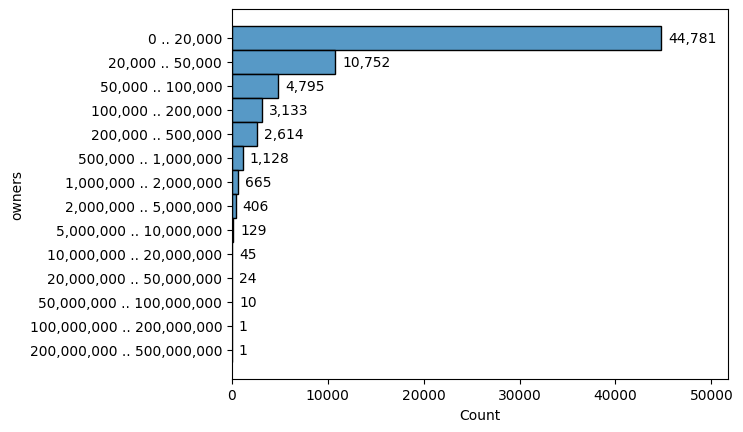

In [101]:
import seaborn as sns

# Create histogram
ax = sns.histplot(data=games, y="owners")

# Add labels
for container in ax.containers:
    ax.bar_label(container, fmt="{:,.0f}", padding=5)

# Increase x limit to fit labels
_ = ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1]*1.1)

We can see that the vast majority of games have below 20,000 owners, with decreasing numbers of games in each larger size bucket. There are a handful of individual games in the largest owners buckets.

Now looking at the tags, let's have a look at the frequencies

<Axes: >

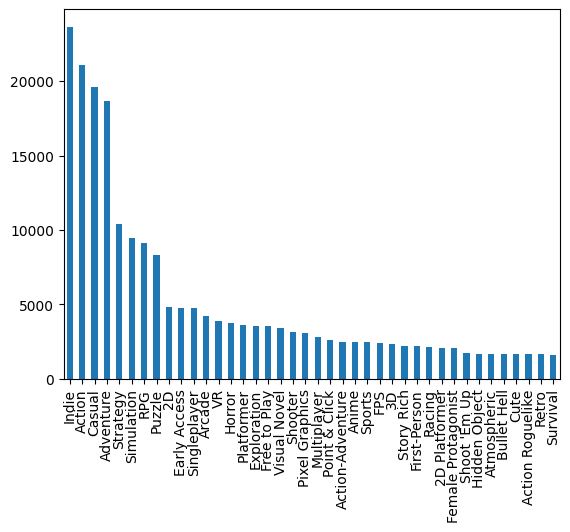

In [87]:
games.filter(like="tag").stack().value_counts()[:40].plot.bar()

A couple of observations:
* The top 4 tags are very frequent, then there is a steep drop to the next four, another steep drop and then a much more gradual progression.
* Most tags describing the genre or gameplay ('action', 'strategy', 'platformer'), but some describe other meta characteristics, graphical style, business model, or just vibes ('VR', 'Pixel Graphics', 'Indie', 'Early access', 'Cute')

Finally, let's look at release dates:

Text(0, 0.5, 'Number of games released')

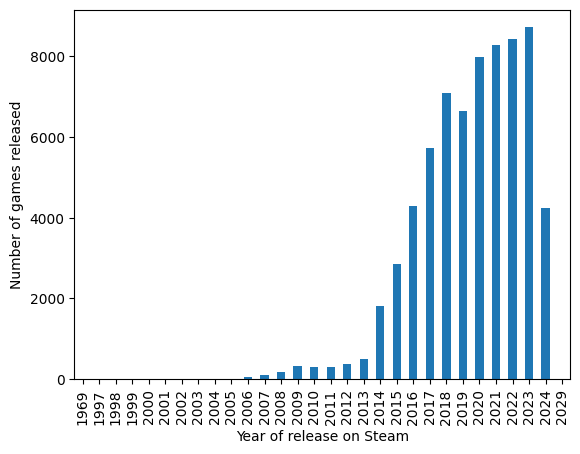

In [126]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

games.dropna(subset='year', inplace=True)
games.groupby(games['date'].dt.year)['name'].count().plot(kind = 'bar', ax=ax)

# Label axes
plt.xlabel("Year of release on Steam")
plt.ylabel("Number of games released")


Steam launched in 2003, and opened up to third party games in 2005. But we can see that the number of games being release on Steam really started taking off in 2014, and has accelerated signfiicantly since.